In [1]:
!python --version

Python 3.7.10


# Embeddings
- [gensim](https://radimrehurek.com/gensim/auto_examples/tutorials/run_annoy.html?highlight=load%20word2vec%20txt#work-with-google-s-word2vec-files) - **why do I need it????**
- [tokenizer](https://github.com/google/sentencepiece/blob/master/python/README.md)


## Load data (separate dataset)
- the 2008-2016 dataset 
- python language

In [2]:
!python -c "import tensorflow as tf;print(tf.reduce_sum(tf.random.normal([1000, 1000])))"

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'tensorflow'


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks 
from tensorflow.keras import optimizers, models

import sentencepiece as spm

In [3]:
!pip --version

pip 20.1.1 from /Users/alinabogdanova/.pyenv/versions/3.7.10/lib/python3.7/site-packages/pip (python 3.7)


In [2]:
df = pd.read_csv("py_df.csv")
df = df.drop(columns=["round", "task", "solution", "file", "full_path", "Unnamed: 0.1", "Unnamed: 0", "lang"])

- Let's remove the sort files, then select users with the highest amount of files

- count lines

In [3]:
df["n_lines"] = df.flines.apply(lambda x: str(x).count("\n"))
df["n_lines"].describe()

count    155359.000000
mean         50.815852
std          70.495160
min           0.000000
25%          27.000000
50%          41.000000
75%          62.000000
max       10052.000000
Name: n_lines, dtype: float64

- let's save files with amount of lines in range `[30; 100]`

In [4]:
df = df[(df.n_lines>=30)&(df.n_lines<=100)]
df.n_lines.describe()

count    96347.000000
mean        53.112406
std         17.997254
min         30.000000
25%         38.000000
50%         49.000000
75%         65.000000
max        100.000000
Name: n_lines, dtype: float64

- let's find avg file length (in chars)

In [5]:
df["n_chars"] = df.flines.apply(lambda x: len(str(x)))
(df.n_chars/df.n_lines).describe()

count    96347.000000
mean        25.218311
std         24.381574
min          9.404255
25%         21.201266
50%         24.256098
75%         27.609035
max       2305.270270
dtype: float64

- suspicious max value let's drop evetyrhing, highter then `100` and look, what's left

In [6]:
df["chars_per_line"] = df.n_chars/df.n_lines
df = df[df.chars_per_line<100]
df.describe()

,year,n_lines,n_chars,chars_per_line
count,96268.000000,96268.000000,96268.000000,96268.000000
mean,2013.419059,53.110462,1320.138987,24.737484
std,2.275480,17.996703,556.480639,5.274293
min,2008.000000,30.000000,322.000000,9.404255
25%,2012.000000,38.000000,903.000000,21.200000
50%,2014.000000,49.000000,1193.000000,24.250000
75%,2016.000000,65.000000,1622.000000,27.600000
max,2016.000000,100.000000,8109.000000,98.937500


- less, then 100 files were removed

## Tokenization
- let's apply embedding to all the source files **LOSE LAYOUT FEATURES**
- * it takes time

Example of lib usage
```python
sp.encode('\tarr = [int(x) for x in str.split()]')
>> [6682, 14, 127, 184, 96091, 96097, 96090, 115, 419, 57, 420, 96084, 1300, 5382]
print(sp.decode(sp.encode('    arr = [int(x) for x in str.split()]')))
>> arr = [int(x) for x in str.split()]
```

In [7]:
sp = spm.SentencePieceProcessor(model_file='embd/sentencepiece_bpe.model')
df.index = np.arange(len(df))
df["n_tokens"] = df.flines.apply(lambda x: len(sp.encode(x)))
df.describe()

,year,n_lines,n_chars,chars_per_line,n_tokens
count,96268.000000,96268.000000,96268.000000,96268.000000,96268.000000
mean,2013.419059,53.110462,1320.138987,24.737484,339.958854
std,2.275480,17.996703,556.480639,5.274293,138.162118
min,2008.000000,30.000000,322.000000,9.404255,88.000000
25%,2012.000000,38.000000,903.000000,21.200000,239.000000
50%,2014.000000,49.000000,1193.000000,24.250000,310.000000
75%,2016.000000,65.000000,1622.000000,27.600000,413.000000
max,2016.000000,100.000000,8109.000000,98.937500,2768.000000


- let's set the threshold of 600 tokens here

In [8]:
df = df[df.n_tokens<=600]
df.describe()

,year,n_lines,n_chars,chars_per_line,n_tokens
count,91608.000000,91608.000000,91608.000000,91608.000000,91608.000000
mean,2013.434067,51.488877,1252.983953,24.386664,321.319295
std,2.267464,16.690541,466.119754,4.848071,108.648343
min,2008.000000,30.000000,322.000000,9.404255,88.000000
25%,2012.000000,38.000000,890.000000,21.045455,236.000000
50%,2014.000000,48.000000,1161.000000,24.000000,302.000000
75%,2016.000000,62.000000,1542.000000,27.225959,395.000000
max,2016.000000,100.000000,6140.000000,85.289474,600.000000


- let's look at the amount of files per participant

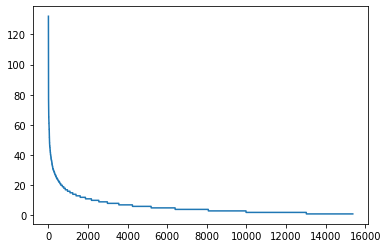

In [9]:
plt.plot(np.array(df.username.value_counts()))

- Let's collect `40` users with avg amount of files, which is around 60
(enough files, but their difference amount is not sufficient)

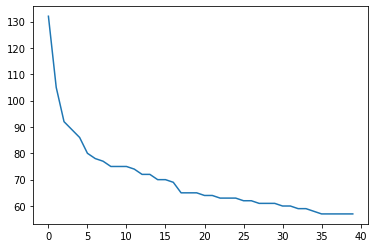

In [10]:
plt.plot(np.array(df.username.value_counts())[:40])

In [11]:
users = df.username.value_counts()[:40].index
df = df[df.username.isin(users)]
df.head()

,year,username,flines,n_lines,n_chars,chars_per_line,n_tokens
0,2008,mth,"#!/usr/bin/env python\n \n def comb(a, b):\n \...",41,870,21.219512,297
5,2008,RalfKistner,"#!/usr/bin/python\n \n fin = open(""d.in"", ""r"")...",50,1040,20.800000,335
12,2008,lidaobing,import sys\n \n def getints(ifile):\n retu...,48,931,19.395833,250
13,2008,lidaobing,import sys\n import psyco\n psyco.full()\n imp...,85,1911,22.482353,480
16,2008,gizzywump,#!/usr/bin/env python\n \n import sys\n \n CAC...,38,885,23.289474,285


- Let's look at the amount of files per person in more details

In [12]:
df.username.value_counts().describe()

count     40.000000
mean      69.775000
std       14.829782
min       57.000000
25%       60.750000
50%       64.500000
75%       75.000000
max      132.000000
Name: username, dtype: float64

- Hope, this is enough and the contrast between the smallest amount and the max, won't be sufficient

In [13]:
df.username.value_counts()

EricStansifer     132
lidaobing         105
mth                92
RalfKistner        89
gizzywump          86
Fj.                80
kmod               78
Michael            77
narri              75
nitsas             75
gepa               75
mihaild            74
waitingkuo0527     72
addie9000          72
pawko              70
Sp3000             70
graygrass          69
ali.assaf          65
xtof.durr          65
Martial            65
d.operator         64
a1ex               64
killerrex          63
linguo             63
raja.baz           63
ymgve              62
zibada             62
takluyver          61
Grzesiu            61
EnTerr             61
tanriol            60
zli                60
Nooodles           59
Fizu               59
Klinck             58
chaoticiak         57
Capp               57
kawasaki           57
Games              57
Vytis              57
Name: username, dtype: int64

In [14]:
df["tokens"] = df.flines.apply(lambda x: sp.encode(x))

In [15]:
df.head()

,year,username,flines,n_lines,n_chars,chars_per_line,n_tokens,tokens
0,2008,mth,"#!/usr/bin/env python\n \n def comb(a, b):\n \...",41,870,21.219512,297,"[3238, 2785, 96124, 1119, 96124, 1376, 1804, 6..."
5,2008,RalfKistner,"#!/usr/bin/python\n \n fin = open(""d.in"", ""r"")...",50,1040,20.800000,335,"[3238, 2785, 96124, 1119, 96124, 1796, 3014, 1..."
12,2008,lidaobing,import sys\n \n def getints(ifile):\n retu...,48,931,19.395833,250,"[138, 1149, 63, 398, 7686, 96091, 96073, 252, ..."
13,2008,lidaobing,import sys\n import psyco\n psyco.full()\n imp...,85,1911,22.482353,480,"[138, 1149, 138, 20653, 62, 20653, 62, 96084, ..."
16,2008,gizzywump,#!/usr/bin/env python\n \n import sys\n \n CAC...,38,885,23.289474,285,"[3238, 2785, 96124, 1119, 96124, 1376, 1804, 1..."


In [16]:
dataset = df[["username", "tokens"]]

In [17]:
dataset

,username,tokens
0,mth,"[3238, 2785, 96124, 1119, 96124, 1376, 1804, 6..."
5,RalfKistner,"[3238, 2785, 96124, 1119, 96124, 1796, 3014, 1..."
12,lidaobing,"[138, 1149, 63, 398, 7686, 96091, 96073, 252, ..."
13,lidaobing,"[138, 1149, 138, 20653, 62, 20653, 62, 96084, ..."
16,gizzywump,"[3238, 2785, 96124, 1119, 96124, 1376, 1804, 1..."
...,...,...
95750,EnTerr,"[46, 46, 9337, 2102, 71465, 9647, 46, 5984, 96..."
96132,Nooodles,"[5059, 9337, 1174, 1250, 144, 9647, 5059, 4474..."
96133,Nooodles,"[5059, 9337, 1174, 1250, 144, 9647, 5059, 4474..."
96134,Nooodles,"[5059, 9337, 1174, 1250, 144, 9647, 5059, 4474..."


## Load data
Lib selected - tensorflow + keras

### Some small notes for future
Tensorflow supports python 3.8 as max version. The issue arises on latest Ubuntu/max os-es, when the default python version is 3.9.

What was done on MAC-OS-Big-Sur to solve that issue.
- [pyenv](https://github.com/pyenv/pyenv) installed
```bash
>> brew update
>> brew install pyenv
...
```
- python 3.7 installation
```
>> brew install python@3.7
```
- pyenv added python 3.7
```
>> pyenv install 3.7.10
>> pyenv loacal 3.7.10
```
- create [myenv](https://www.tensorflow.org/install/pip#2.-create-a-virtual-environment-recommended)
```
>> python3.7 -m venv myenv
>> source myenv/bin/activate.fish
```
- solution of the final problem - **UPGRADE PIP**
- install tensorflow
```
(myenv)>> pip install --upgrade tensorflow
```

In [18]:
le = LabelEncoder()
dataset.username = le.fit_transform(dataset.username)

/Users/alinabogdanova/Documents/workspace/research/myenv/lib/python3.7/site-packages/pandas/core/generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [19]:
# shuffle dataset
dataset = dataset.sample(frac = 1) 
dataset

,username,tokens
63396,25,"[138, 1149, 28, 14, 49585, 871, 96111, 250, 80..."
61568,15,"[138, 1149, 138, 5045, 63, 12687, 96077, 12674..."
11768,2,"[138, 1149, 96085, 566, 57, 96077, 252, 14, 15..."
81855,29,"[138, 1149, 138, 2684, 63, 178, 2374, 586, 115..."
60935,20,"[3238, 2785, 96124, 1119, 96124, 1376, 1804, 1..."
...,...,...
7682,9,"[138, 1149, 63, 921, 96077, 3513, 586, 121, 65..."
13113,4,"[138, 13649, 138, 1149, 138, 34, 138, 611, 156..."
3289,36,"[3238, 2785, 96124, 1119, 96124, 1796, 46, 28,..."
20043,11,"[3238, 2785, 96124, 1119, 96124, 1796, 46, 138..."


In [20]:
def rsh(x):
    arr = np.array(x)
    arr.resize(600)
    return list(arr)

dataset.tokens = dataset.tokens.apply(rsh)

In [21]:
dataset

,username,tokens
63396,25,"[138, 1149, 28, 14, 49585, 871, 96111, 250, 80..."
61568,15,"[138, 1149, 138, 5045, 63, 12687, 96077, 12674..."
11768,2,"[138, 1149, 96085, 566, 57, 96077, 252, 14, 15..."
81855,29,"[138, 1149, 138, 2684, 63, 178, 2374, 586, 115..."
60935,20,"[3238, 2785, 96124, 1119, 96124, 1376, 1804, 1..."
...,...,...
7682,9,"[138, 1149, 63, 921, 96077, 3513, 586, 121, 65..."
13113,4,"[138, 13649, 138, 1149, 138, 34, 138, 611, 156..."
3289,36,"[3238, 2785, 96124, 1119, 96124, 1796, 46, 28,..."
20043,11,"[3238, 2785, 96124, 1119, 96124, 1796, 46, 138..."


In [22]:
X = dataset.tokens.values
X = np.array(list(X))
X.shape

(2791, 600)

In [23]:
X = X.reshape((-1, 600, 1))
y = np.array(dataset.username)

ohe = OneHotEncoder()
y = ohe.fit_transform(y.reshape(-1, 1))
y = y.toarray()

X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train.shape

(2093, 600, 1)

### Structure of the model
1. CNN:
- ks = 50 (function - level)
- ks = 10 (line2 - level)
- ks = 5 (lene - level)
2. Linear ReLU 
3. softmax 75

> important note `tanh` activation increases accuracy from 11% to 60% ontraining (50% of test accuracy)
>
> `linear` function reaches up to 61% of test accuracy

In [36]:
model = keras.Sequential()
model.add(keras.Input(shape=(600, 1)))  
model.add(layers.Conv1D(150, 10, activation="linear")) 
model.add(layers.MaxPooling1D(pool_size=8))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation="linear"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(20, activation="softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 491, 150)          1650      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 61, 150)           0         
_________________________________________________________________
flatten (Flatten)            (None, 9150)              0         
_________________________________________________________________
dropout (Dropout)            (None, 9150)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                585664    
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                1

In [37]:
optimizer = optimizers.Adam(0.1)
lr_schedule = callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, min_delta=0.000001, verbouse=1)
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [53]:
epochs = 100
batch_size = 20
history = model.fit(x=X_train, y=y_train, epochs = epochs, 
                    validation_data = (X_test,y_test),
                    steps_per_epoch=X_train.shape[0] // batch_size,
                    verbose=2, 
                    callbacks=[lr_schedule])

Epoch 1/100
52/52 - 1s - loss: 13984887.0000 - accuracy: 0.1062 - val_loss: 14515340.0000 - val_accuracy: 0.1829
Epoch 2/100
52/52 - 1s - loss: 26092528.0000 - accuracy: 0.2005 - val_loss: 26890764.0000 - val_accuracy: 0.3400
Epoch 3/100
52/52 - 1s - loss: 80722776.0000 - accuracy: 0.2170 - val_loss: 78943864.0000 - val_accuracy: 0.2800
Epoch 4/100
52/52 - 1s - loss: 147038864.0000 - accuracy: 0.2766 - val_loss: 106388136.0000 - val_accuracy: 0.3257
Epoch 5/100
52/52 - 1s - loss: 166961008.0000 - accuracy: 0.3361 - val_loss: 156073104.0000 - val_accuracy: 0.4086
Epoch 6/100
52/52 - 1s - loss: 201975936.0000 - accuracy: 0.3828 - val_loss: 186361776.0000 - val_accuracy: 0.4286
Epoch 7/100
52/52 - 1s - loss: 221577664.0000 - accuracy: 0.4377 - val_loss: 235092080.0000 - val_accuracy: 0.5457
Epoch 8/100
52/52 - 1s - loss: 277531584.0000 - accuracy: 0.4515 - val_loss: 313194592.0000 - val_accuracy: 0.5371
Epoch 9/100
52/52 - 1s - loss: 250069904.0000 - accuracy: 0.5641 - val_loss: 267062624

In [24]:
def plot_training(history):
    fig = plt.figure(figsize=(12, 5))
    plt.subplot(121)
    plt.title("Loss")
    plt.plot(history.history['loss'], color='b', label="Training loss")
    plt.plot(history.history['val_loss'], color='r', label="validation loss")
    plt.legend(loc='best', shadow=True)

    plt.subplot(122)
    plt.title("Accuracy")
    plt.plot(history.history['accuracy'], color='b', label="Training accuracy")
    plt.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
    plt.legend(loc='best', shadow=True)
    return fig

In [38]:
f = plot_training(history)

NameError: name 'history' is not defined

#### 64% test accuracy

```python
model = keras.Sequential()
model.add(keras.Input(shape=(500, 1)))  
model.add(layers.Conv1D(100, 32, activation="linear"))
model.add(layers.MaxPooling1D(pool_size=4))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(32, activation="linear"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(20, activation="softmax"))
model.summary()
```

#### up to 76% test accuracy
```python
model = keras.Sequential()
model.add(keras.Input(shape=(500, 1)))  
model.add(layers.Conv1D(100, 16, activation="linear")) 
model.add(layers.MaxPooling1D(pool_size=4))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation="linear"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(20, activation="softmax"))
model.summary()
```

#### converges to 76% test accuracy
```python
model = keras.Sequential()
model.add(keras.Input(shape=(500, 1)))  
model.add(layers.Conv1D(100, 8, activation="linear")) 
model.add(layers.MaxPooling1D(pool_size=4))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation="linear"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(20, activation="softmax"))
model.summary()
```

#### 77% of test accuracy
```python
model = keras.Sequential()
model.add(keras.Input(shape=(500, 1))) 
model.add(layers.Conv1D(150, 8, activation="linear")) 
model.add(layers.MaxPooling1D(pool_size=6))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation="linear"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(20, activation="softmax"))
model.summary()
```

#### confident 81%
```python
model = keras.Sequential()
model.add(keras.Input(shape=(500, 1)))  
model.add(layers.Conv1D(128, 16, activation="linear")) 
model.add(layers.MaxPooling1D(pool_size=8))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation="linear"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(20, activation="softmax"))
model.summary()
```

#### up to 81.71%
```python
model = keras.Sequential()
model.add(keras.Input(shape=(500, 1))) 
model.add(layers.Conv1D(128, 16, activation="linear", strides=2)) 
model.add(layers.MaxPooling1D(pool_size=8))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation="linear"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(20, activation="softmax"))
model.summary()
```

#### converges to 80%
```python
model = keras.Sequential()
model.add(keras.Input(shape=(500, 1)))  
model.add(layers.Conv1D(150, 10, activation="linear")) 
model.add(layers.MaxPooling1D(pool_size=8))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation="linear"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(20, activation="softmax"))
model.summary()
```

- Also the structures with 2 Convolutional layers were tested (up to 50% accuracy)
- Avg Pooling works poarly due to the fact, that the initial data is not normalized

In [25]:
from sklearn.metrics import confusion_matrix
import itertools

def plt_conf_matrix(cm, classes):
    cmap=plt.cm.Blues
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)


    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
     

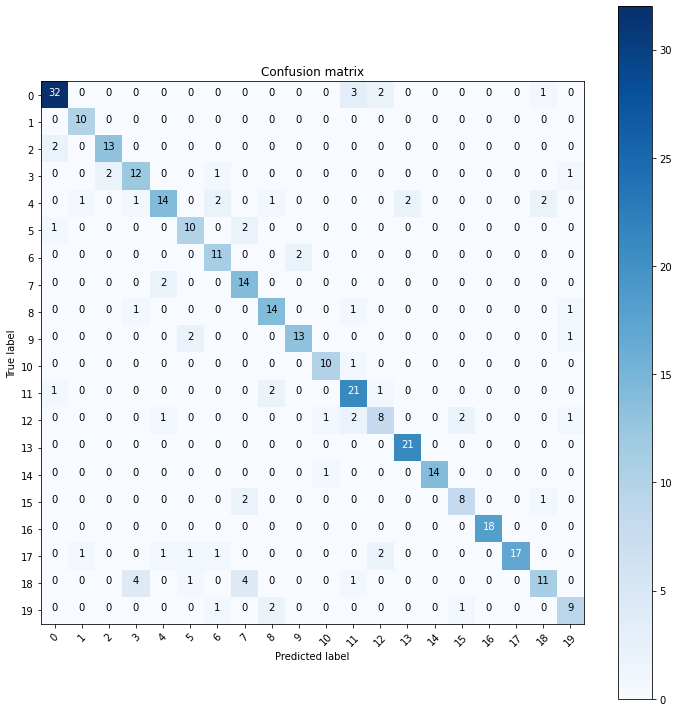

In [55]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis = 1) 
y_true = np.argmax(y_test, axis = 1) 
confusion_mtx = confusion_matrix(y_true, y_pred_classes) 
plt_conf_matrix(confusion_mtx, classes = range(20))

In [56]:
model.save('model.h5')

I don't know, what are these ebbeddings, but...

## Let's apply normalization
(thus `relu`, `than` and other activations may be used)

In [26]:
from sklearn.preprocessing import StandardScaler

In [27]:
print(X.min(), X.mean(), X.max())

0 15834.327453123135 99263


As it can be seen, the avg value is far from it's maximum value, thus it is more readonable to apply Standard Scaling

In [28]:
ss = StandardScaler()
X = X.reshape((-1, 600))
X = ss.fit_transform(X)
X = X.reshape((-1, 600, 1))

X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train.shape

(2093, 600, 1)

In [29]:
model = keras.Sequential()
model.add(keras.Input(shape=(500, 1)))
model.add(layers.Conv1D(64, 16, activation="tanh"))
model.add(layers.MaxPooling1D(pool_size=8))
model.add(layers.Conv1D(32, 4, activation="linear")) 
model.add(layers.MaxPooling1D(pool_size=8))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation="linear"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(20, activation="softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 485, 64)           1088      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 60, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 57, 32)            8224      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 7, 32)             0         
_________________________________________________________________
flatten (Flatten)            (None, 224)               0         
_________________________________________________________________
dropout (Dropout)            (None, 224)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                1

In [44]:
optimizer = optimizers.Adam(0.01)
lr_schedule = callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, min_delta=0.000001, verbouse=1)
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [86]:
epochs = 100
batch_size = 20
history = model.fit(x=X_train, y=y_train, epochs = epochs, 
                    validation_data = (X_test,y_test),
                    steps_per_epoch=X_train.shape[0] // batch_size,
                    verbose=2, 
                    callbacks=[lr_schedule])

Epoch 1/100
52/52 - 1s - loss: 3.1951 - accuracy: 0.0870 - val_loss: 2.6906 - val_accuracy: 0.2200
Epoch 2/100
52/52 - 1s - loss: 2.7350 - accuracy: 0.2152 - val_loss: 2.3566 - val_accuracy: 0.3486
Epoch 3/100
52/52 - 1s - loss: 2.4720 - accuracy: 0.2866 - val_loss: 1.8447 - val_accuracy: 0.4657
Epoch 4/100
52/52 - 0s - loss: 2.4828 - accuracy: 0.3196 - val_loss: 1.8237 - val_accuracy: 0.4829
Epoch 5/100
52/52 - 1s - loss: 2.4649 - accuracy: 0.3315 - val_loss: 1.9612 - val_accuracy: 0.4571
Epoch 6/100
52/52 - 1s - loss: 2.4506 - accuracy: 0.3260 - val_loss: 1.7664 - val_accuracy: 0.4886
Epoch 7/100
52/52 - 1s - loss: 2.4044 - accuracy: 0.3443 - val_loss: 1.6923 - val_accuracy: 0.5286
Epoch 8/100
52/52 - 0s - loss: 2.3946 - accuracy: 0.3672 - val_loss: 1.6624 - val_accuracy: 0.5286
Epoch 9/100
52/52 - 1s - loss: 2.2628 - accuracy: 0.3892 - val_loss: 1.5931 - val_accuracy: 0.5514
Epoch 10/100
52/52 - 0s - loss: 2.4094 - accuracy: 0.3773 - val_loss: 1.4267 - val_accuracy: 0.5686
Epoch 11/

#### 80% accuracy (previous model)
```python
model = keras.Sequential()
model.add(keras.Input(shape=(500, 1)))
model.add(layers.Conv1D(150, 10, activation="linear")) 
model.add(layers.MaxPooling1D(pool_size=8))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation="linear"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(20, activation="softmax"))
model.summary()
```

#### 82%
```python
model = keras.Sequential()
model.add(keras.Input(shape=(500, 1)))
model.add(layers.Conv1D(128, 16, activation="tanh"))
model.add(layers.MaxPooling1D(pool_size=8))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation="linear"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(20, activation="softmax"))
model.summary()
```

#### 86% up to 87%
```python
model = keras.Sequential()
model.add(keras.Input(shape=(500, 1)))
model.add(layers.Conv1D(64, 16, activation="tanh"))
model.add(layers.MaxPooling1D(pool_size=8))
model.add(layers.Conv1D(32, 4, activation="linear")) 
model.add(layers.MaxPooling1D(pool_size=8))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation="linear"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(20, activation="softmax"))
model.summary()
```

#### 84%
```python
model = keras.Sequential()
model.add(keras.Input(shape=(500, 1)))
model.add(layers.Conv1D(64, 16, activation="tanh"))
model.add(layers.MaxPooling1D(pool_size=8))
model.add(layers.Conv1D(32, 4, activation="linear")) 
model.add(layers.MaxPooling1D(pool_size=4))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation="linear"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(20, activation="softmax"))
model.summary()
```
#### 84%
```python
model = keras.Sequential()
model.add(keras.Input(shape=(500, 1)))
model.add(layers.Conv1D(64, 16, activation="tanh"))
model.add(layers.AveragePooling1D(pool_size=8))
model.add(layers.Conv1D(32, 8, activation="linear")) 
model.add(layers.AveragePooling1D(pool_size=4))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation="linear"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(20, activation="softmax"))
model.summary()
```

#### 83%
```python
model = keras.Sequential()
model.add(keras.Input(shape=(500, 1)))
model.add(layers.Conv1D(128, 16, activation="relu"))
model.add(layers.MaxPooling1D(pool_size=8))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation="linear"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(20, activation="softmax"))
model.summary()
```

In [87]:
model.save('86_model.h5')

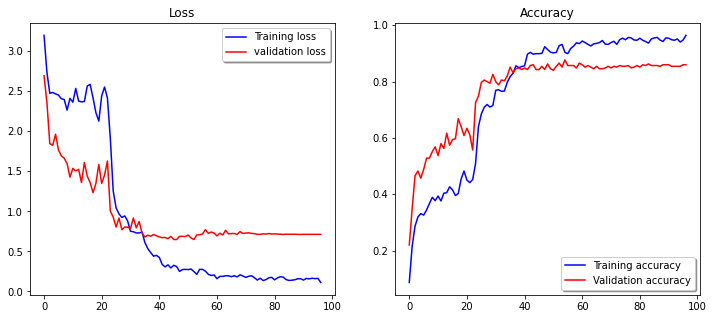

In [88]:
f = plot_training(history)

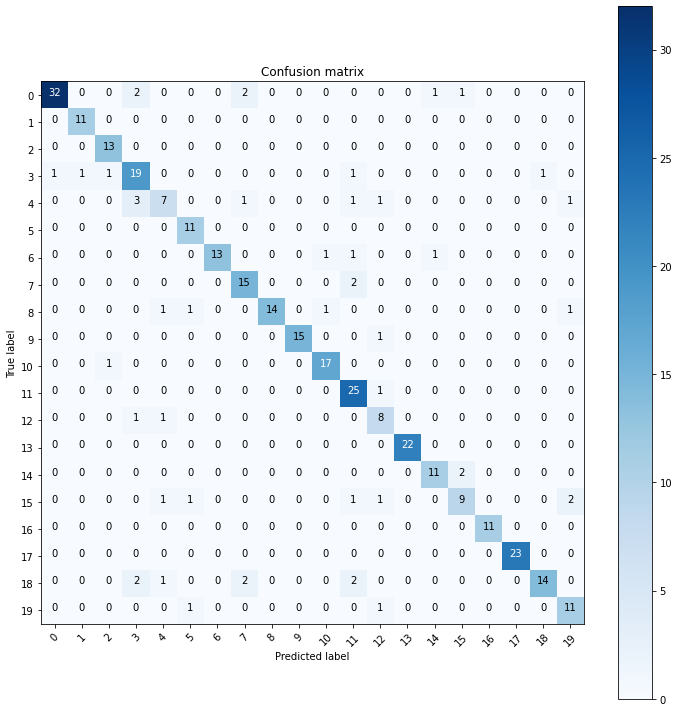

In [89]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis = 1) 
y_true = np.argmax(y_test, axis = 1) 
confusion_mtx = confusion_matrix(y_true, y_pred_classes) 
plt_conf_matrix(confusion_mtx, classes = range(20))

## Triplet loss
- useful [link1](https://zhangruochi.com/Create-a-Siamese-Network-with-Triplet-Loss-in-Keras/2020/08/11/ ), [link2](https://codepad.co/snippet/triplet-loss-in-keras-tensorflow-backend)

### Main idea (If I understood correctly)
- create embedding for embeddings (?)
- apply KNN to find the closest vectors - if the problem is related to the classification

### Data preprocessing flow:
1. Split X[-1, 500] on pices of [-1, 100] and increase the dimensionality of array
2. Shuffle ???
3. Create batch_loader:
        3.1. Select anchor samples (**TODO** search if it is usually done sequentially or randomly)
        3.2. Select some X, where y is the same (random or sequential???)
        3.3. Select some X, where y is different (random or sequential???)
4. Create model (e.g. Sequential)
5. Concatenate 3 models for anchor, positives an negatives // this is exactly the parallel convolution, which I was searching during the previous stages
6. Create a functions `loss` and `data_generator`
7. Train model with dummy y (e.g 0) ([good example](https://github.com/AdrianUng/keras-triplet-loss-mnist#visualizing-separation-of-classes ), [their code](https://github.com/AdrianUng/keras-triplet-loss-mnist/blob/master/Triplet_loss_KERAS_semi_hard_from_TF.ipynb))
8. Apply the visualization with PCA/test on KNN????

### Make samples smaller, e.g. 100
- potential problem - files are ended with zeros, if amount of tokens is less


In [113]:
def crop_to(X, y, crop=100, threshold=80):
    new_X = []
    new_y = []
    for old_x, old_y in zip(X, y):
        for el in old_x.reshape(-1, 100):
            if(np.count_nonzero(el) > 80):
                new_X.append(list(el))
                new_y.append(np.argmax(old_y))
    
    new_X = np.array(new_X).reshape(-1, crop, 1)
    new_y = np.array(new_y)
    return new_X, new_y

# new_X, new_y = crop_to(X, y)
new_X, new_y = X, np.argmax(y, axis=1)

In [92]:
new_X.shape

(2791, 600, 1)

In [32]:

data_length = new_y.shape[0]

### Shuffle - do I need this?
- No, because in the batch I'm going to use random

### Batch generation

In [33]:
def batch_generator(X, y):
    
    data_length = X.shape[0]
    index = np.random.randint(data_length)
    anchor, anchor_y = X[index], y[index]
    
    positive = X[np.random.choice(np.where(y==anchor_y)[0])]
    negative = X[np.random.choice(np.where(y!=anchor_y)[0])]
    
    return [list(anchor), list(positive), list(negative)]

def batches_generator(X, y, batch_size=32):
    '''
    Array of batch_generator results
    
    batch_size - size of the generated array
    '''
    all_data = np.array([batch_generator(X, y) for i in range(batch_size)])
    anchors = all_data[:, 0, :]
    positives = all_data[:, 1, :]
    negatives = all_data[:, 2, :]
    return anchors, positives, negatives

def data_generator(X, y, batch_size=32, input_size=600):
    while True:
        batch = batches_generator(X, y, batch_size)
        labels = np.zeros((batch_size, input_size*3)) 
        yield batch, labels
        


### Model creation


- let's repeat the best arch

In [34]:
import tensorflow as tf
from tensorflow.keras import regularizers


from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [35]:
params = {
    "activations" : ["tanh", "relu", "elu", "sigmoid", "linear", "selu", "gelu", "swish"],
    #"output_sizes" : [50, 100, 500],
    "L2_lambda": [0.01, 0.001, 0.0001],
    "pool_1_size": [4, 8],
    "pool_2_size":[4, 8],
    "conv_1_size": [16, 32, 64],
    "conv_2_size":[4, 8],
    "dense_1": [64]   
}
params = {
    "activations" : ["relu"],
    #"output_sizes" : [50, 100, 500],
    "L2_lambda": [0.001],
    "pool_1_size": [4, 8],
    "pool_2_size":[4, 8],
    "conv_1_size": [8, 16],
    "conv_2_size":[4, 8],
    "dense_1": [64]   
}
params = {
    "activations" : ["tanh"],
    #"output_sizes" : [50, 100, 500],
    "L2_lambda": [0.001],
    "pool_1_size": [8],
    "pool_2_size":[4],
    "conv_1_size": [16],
    "conv_2_size":[8],
    "dense_1": [128]     
}

In [36]:
new_X.shape, new_y.shape

((2791, 600, 1), (2791,))

In [37]:
output_size = 50
input_size = 600

In [38]:
def create_model(activation="linear", L2_lambda=0.02, 
                 pool_1_size=4, pool_2_size=4, 
                 conv_1_size=16, conv_2_size=4, dense_1=64):
    
    model_core = keras.Sequential()
    model_core.add(layers.Conv1D(64, conv_1_size, 
                                 activation=activation, 
                                 kernel_regularizer=regularizers.L2(L2_lambda)))
    
    model_core.add(layers.LayerNormalization(axis=1))
    model_core.add(layers.MaxPooling1D(pool_size=pool_1_size))
    
    model_core.add(layers.Conv1D(32, conv_2_size, 
                                 activation=activation, 
                                 kernel_regularizer=regularizers.L2(L2_lambda)))

    model_core.add(layers.LayerNormalization(axis=1))
    model_core.add(layers.MaxPooling1D(pool_size=pool_2_size))
    
    model_core.add(layers.Flatten())
    model_core.add(layers.Dropout(0.5))
    model_core.add(layers.Dense(dense_1, activation=activation, 
                                kernel_regularizer=regularizers.L2(L2_lambda)))
    model_core.add(layers.LayerNormalization(axis=1))
    
    model_core.add(layers.Dropout(0.5))
    model_core.add(layers.Dense(output_size, activation=activation, 
                                kernel_regularizer=regularizers.L2(L2_lambda)))
    model_core.add(layers.LayerNormalization(axis=1))
    return model_core


In [39]:
def triplet_loss(y_true, y_pred):
    alpha = 0.2
    y_pred = tf.convert_to_tensor(y_pred)
    global output_size
    anchor = y_pred[:, :output_size]
    positive = y_pred[:, output_size:2*output_size]
    negative = y_pred[:, 2*output_size:]
    
    positive_dist = tf.reduce_mean(tf.square(anchor - positive), axis=1)
    negative_dist = tf.reduce_mean(tf.square(anchor - negative), axis=1)

    return tf.maximum(positive_dist - negative_dist + alpha, 0.)

In [40]:
def create_triplet_model(input_size, model_core):
    
    input_anchor = layers.Input(shape=(input_size, 1))
    input_positive = layers.Input(shape=(input_size, 1))
    input_negative = layers.Input(shape=(input_size, 1))

    model_anchor = model_core(input_anchor)
    model_positive = model_core(input_positive)
    model_negative = model_core(input_negative)

    result = layers.concatenate([model_anchor, model_positive, model_negative], axis=1)
    model = models.Model([input_anchor, input_positive, input_negative], result)
    return model


In [41]:
def train(new_X, new_y, input_size, model):
    batch_size = 64
    epochs = 100
    steps_per_epoch = int(new_X.shape[0]/batch_size)

    optimizer = optimizers.Adam(0.1)
    lr_schedule = callbacks.ReduceLROnPlateau(monitor='loss', actor=0.5, patience=2, min_delta=0.000001, verbouse=1)
    early_stopping = callbacks.EarlyStopping(monitor="loss", min_delta = 0.0001, patience=5, restore_best_weights=True)

    model.compile(loss=triplet_loss, optimizer=optimizer)
    history = model.fit(data_generator(new_X, new_y, batch_size, input_size),
                        steps_per_epoch=steps_per_epoch,
                        epochs=epochs, 
                        verbose=0, 
                        callbacks=[lr_schedule, early_stopping])
    return model, history


In [212]:
from sklearn.metrics import f1_score, precision_score, recall_score

In [229]:
def test(model_core, new_X, new_y):
    transformed_X = model_core.predict(new_X.reshape(-1, input_size, 1))
    X_train, X_test, y_train, y_test = train_test_split(transformed_X, new_y)
    
   
    knn = KNeighborsClassifier(n_neighbors=3, algorithm="ball_tree", weights="distance")
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    
    score = accuracy_score(y_test, y_pred)
    
    return score

In [43]:
param_list = []
for key in params.keys():
    if len(param_list)==0:
        for x in params[key]:
            param_list.append([x])
    else:
        new_param_list = []
        for l in param_list:
            for x in params[key]:
                l_copy = l.copy()
                l_copy.append(x)
                new_param_list.append(l_copy)
        param_list = new_param_list
len(param_list)

1

In [44]:
param_list[0]

['tanh', 0.001, 8, 4, 16, 8, 128]

In [45]:
import tqdm

In [50]:
max_score = 0
best_model = None
log = []
core_model = None
for p in tqdm.tqdm(param_list):
    core_model = create_model(*p)
    triplet = create_triplet_model(input_size, core_model)
    model, history = train(new_X, new_y, input_size, triplet)
    score = test(core_model, new_X, new_y)
    if score > max_score:
        max_score = score
        best_model = model
        print(p, score)
    log.append({"score": score, "history": history, "params": p})


100%|██████████| 1/1 [05:57<00:00, 357.52s/it]

['tanh', 0.001, 8, 4, 16, 8, 128] 0.4785100286532951


In [47]:
print(len(log))

1


In [158]:
log_df = pd.DataFrame(log)

In [159]:
log_df

,score,history,params
0,0.47851,<tensorflow.python.keras.callbacks.History obj...,"[tanh, 0.001, 8, 4, 16, 8, 128]"


In [160]:
log_df["history_arr"] = log_df.history.apply(lambda x: x.history["loss"])

In [161]:
log_df["activations"] = log_df.params.apply(lambda x:x[0])
log_df["L2_lambda"]  = log_df.params.apply(lambda x:x[1])
log_df[ "pool_1_size"] = log_df.params.apply(lambda x:x[2])
log_df[ "pool_2_size"] = log_df.params.apply(lambda x:x[3])
log_df["conv_1_size"] = log_df.params.apply(lambda x:x[4])
log_df["conv_2_size"] = log_df.params.apply(lambda x:x[5])
log_df["dense_1"] = log_df.params.apply(lambda x:x[6])

In [162]:
log_df = log_df.drop(columns=["history", "params"])

In [163]:
log_df.score.describe()

count    1.00000
mean     0.47851
std          NaN
min      0.47851
25%      0.47851
50%      0.47851
75%      0.47851
max      0.47851
Name: score, dtype: float64

#### All the tame accuracy was approximately the same

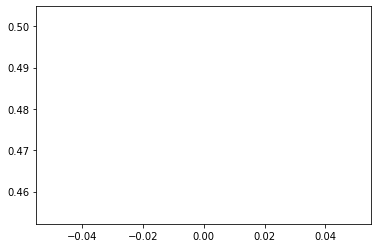

In [164]:
plt.plot(log_df.score)

### How the best model was trained?

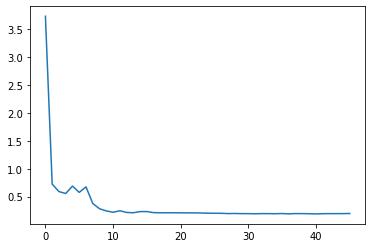

In [165]:
plt.plot(log_df.history_arr[0])

In [133]:
log_df.to_csv("grid_6.csv")

In [134]:
log_df.to_json("grid_6.json")# arrays could be exported better (history)

-  52% - 20-40 by amount of files, 600 input - 100 output
-  53% - 20-40 by amount of files, 600 input - 200 output
-  53% - 20-40 by amount of files, 600 input - 400 output
- 33% - 20-40 by amount of files, 100 input - 100 output
-  49.7% - 0-40 by amount of files, 600 input - 100 output

### Read more
- [implementation by tensorflow](https://www.tensorflow.org/addons/tutorials/losses_triplet)

## What's going on!?
Why the accuracy is so low! Let's look at the PCA of the daataset

In [48]:
import numpy as np
from sklearn.decomposition import PCA

In [49]:
# pass the data through the model

In [166]:
vectorized_X = core_model.predict(new_X)

In [167]:
vectorized_X.shape

(2791, 50)

In [187]:
pca = PCA(n_components=3)

In [188]:
pca.fit(vectorized_X)

PCA(n_components=3)

In [189]:
pca_x = pca.transform(vectorized_X)

In [190]:
pca_x.shape

(2791, 3)

In [191]:
new_y
y1d = np.argmax(new_y, axis=1)

In [192]:
y1d

array([25, 15,  2, ..., 36, 11,  5])

In [193]:
pca_x[np.where(y1d==i), 0]

array([[ 1.1772183 , -1.3001659 , -1.2852442 , -1.2939637 , -1.3005676 ,
        -1.2958633 , -1.2922027 , -1.2931207 ,  1.4757564 , -1.2852442 ,
        -1.2798644 , -0.37518644,  1.913398  , -1.2986143 , -1.2966594 ,
        -1.2922027 , -1.2894125 ,  1.739376  ,  1.903196  , -1.2979999 ,
        -0.51277906, -1.2798644 ,  1.8092322 , -1.2979999 ,  1.8338058 ,
        -1.2937647 , -0.37518644, -0.9837514 , -1.2986143 , -1.3001659 ,
         1.9466072 , -1.3073623 ,  1.9351469 ,  1.903196  , -1.2931207 ,
         1.9466072 ,  1.9122374 ,  1.9122374 ,  1.739376  , -1.0333844 ,
        -1.2966594 , -1.2894179 ,  1.8696494 , -1.2899443 , -1.3073623 ,
         1.9361001 ,  1.4757564 , -1.3061833 , -1.2892073 , -0.9837514 ,
        -1.294278  , -1.2819903 ,  1.9307586 ,  0.77661943,  1.9303097 ,
        -1.2942781 , -0.99591476, -1.3061833 ,  1.944403  ,  1.92614   ]],
      dtype=float32)

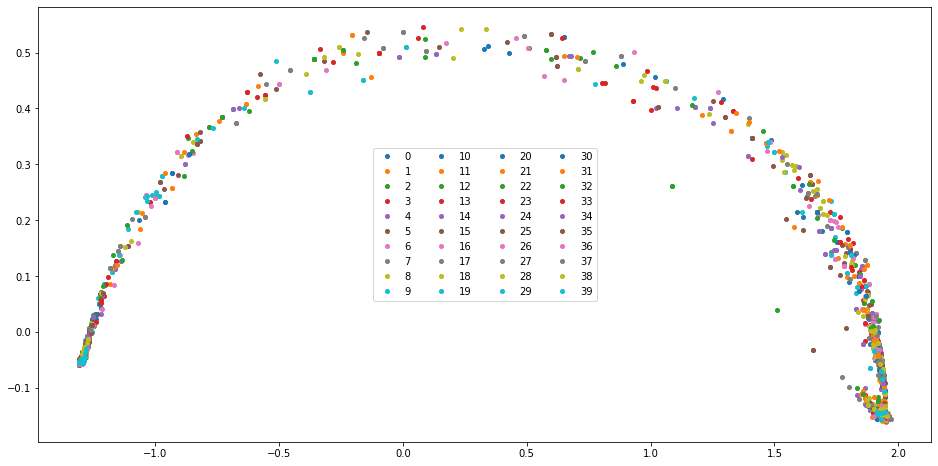

In [196]:
plt.figure(figsize=(16, 8))
for i in range(40):
    plt.plot(pca_x[np.where(y1d==i), 0][0], pca_x[np.where(y1d==i), 1][0], 'o', ms=4, label=str(i))
plt.legend(ncol=4)

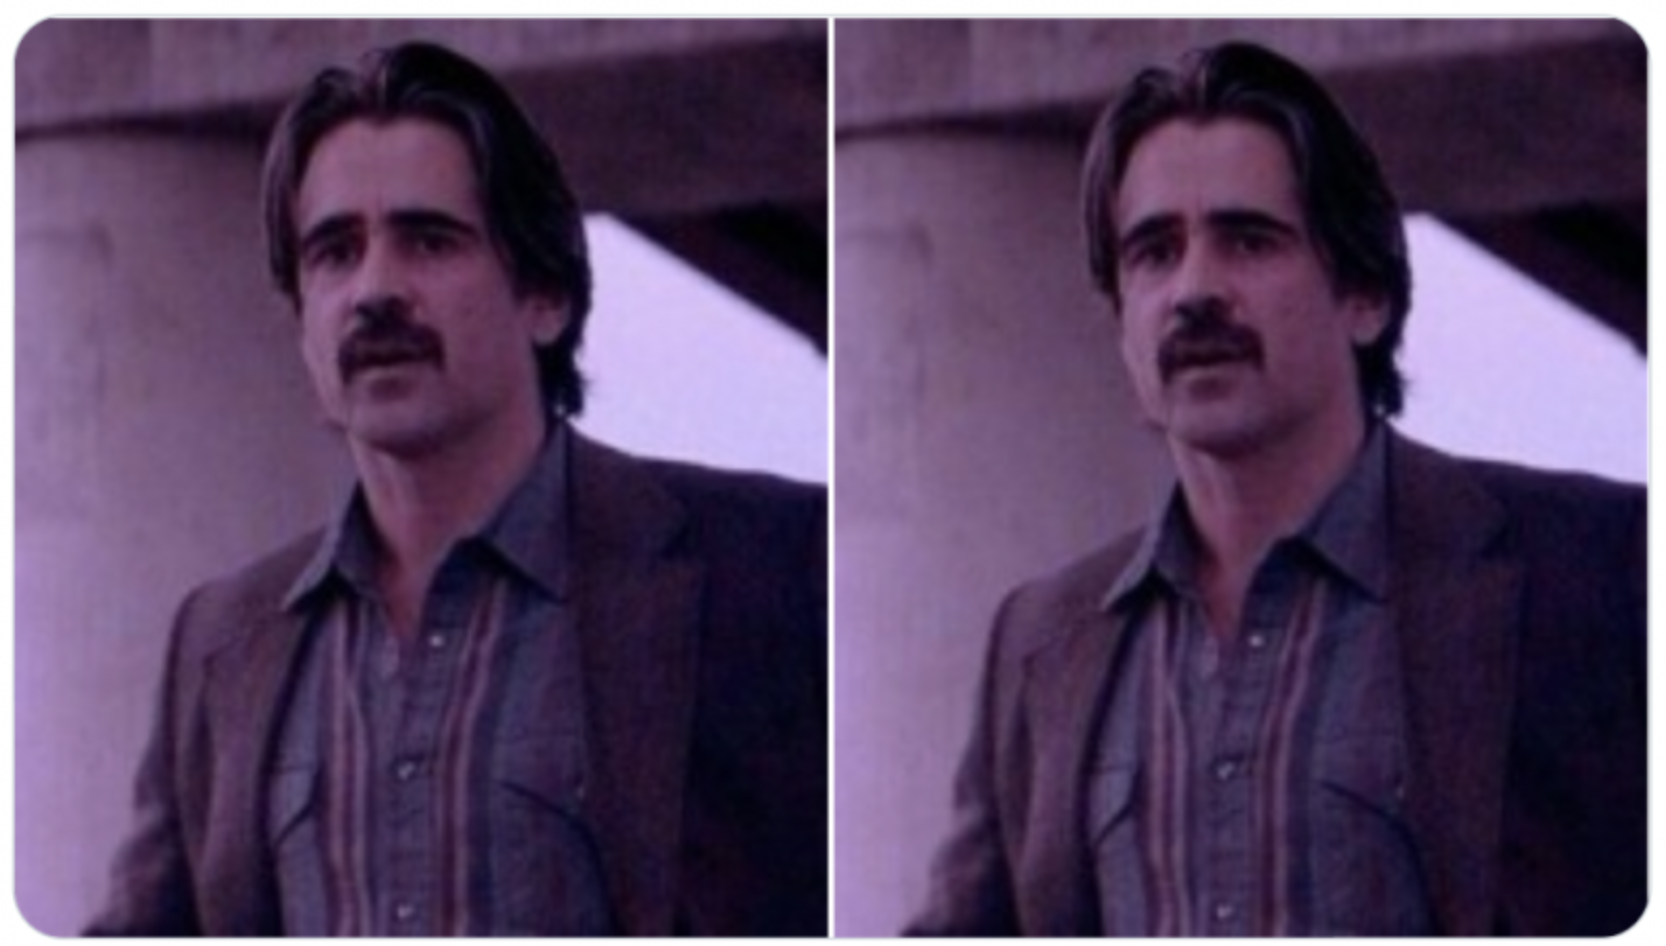


### Ok... Let's train the model on the top of the embeddings

In [114]:
new_y
ohe = OneHotEncoder()
new_y = ohe.fit_transform(new_y.reshape(-1, 1))
new_y = new_y.toarray()

In [132]:
classifier = keras.Sequential()
classifier.add(layers.Input((1, 50)))
classifier.add(layers.Dense(128, activation="relu"))
classifier.add(layers.LayerNormalization(axis=1))
classifier.add(layers.Dropout(0.5))
classifier.add(layers.Dense(64, activation="tanh"))
classifier.add(layers.LayerNormalization(axis=1))
classifier.add(layers.Dropout(0.5))
classifier.add(layers.Dense(40, activation="softmax"))

In [133]:
vectorized_X.shape

(2791, 50)

In [134]:
new_y.shape

(2791, 40)

In [135]:
batch_size = 64
epochs = 100
steps_per_epoch = int(vectorized_X.shape[0]/batch_size)

optimizer = optimizers.Adam(0.1)
lr_schedule = callbacks.ReduceLROnPlateau(monitor='loss', actor=0.5, patience=2, min_delta=0.000001, verbouse=1)
early_stopping = callbacks.EarlyStopping(monitor="loss", min_delta = 0.0001, patience=5, restore_best_weights=True)


classifier.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
history = classifier.fit(x=vectorized_X, y=new_y, epochs = epochs, 
                        validation_data = (vectorized_X,new_y),
                        steps_per_epoch=vectorized_X.shape[0] // batch_size,
                        verbose=2, 
                        callbacks=[lr_schedule, early_stopping])

Epoch 1/100
43/43 - 1s - loss: 4.0073 - accuracy: 0.0272 - val_loss: 3.6997 - val_accuracy: 0.0222
Epoch 2/100
43/43 - 0s - loss: 3.7009 - accuracy: 0.0423 - val_loss: 3.6829 - val_accuracy: 0.0473
Epoch 3/100
43/43 - 0s - loss: 3.6984 - accuracy: 0.0423 - val_loss: 3.6777 - val_accuracy: 0.0473
Epoch 4/100
43/43 - 0s - loss: 3.6998 - accuracy: 0.0391 - val_loss: 3.6785 - val_accuracy: 0.0473
Epoch 5/100
43/43 - 0s - loss: 3.7150 - accuracy: 0.0416 - val_loss: 3.6815 - val_accuracy: 0.0473
Epoch 6/100
43/43 - 0s - loss: 3.6818 - accuracy: 0.0462 - val_loss: 3.6766 - val_accuracy: 0.0473
Epoch 7/100
43/43 - 0s - loss: 3.6781 - accuracy: 0.0469 - val_loss: 3.6711 - val_accuracy: 0.0473
Epoch 8/100
43/43 - 0s - loss: 3.6735 - accuracy: 0.0473 - val_loss: 3.6703 - val_accuracy: 0.0473
Epoch 9/100
43/43 - 0s - loss: 3.6733 - accuracy: 0.0473 - val_loss: 3.6705 - val_accuracy: 0.0473
Epoch 10/100
43/43 - 0s - loss: 3.6734 - accuracy: 0.0473 - val_loss: 3.6696 - val_accuracy: 0.0473
Epoch 11/

- [x] Plot data with PCA
- [x] Train more sophisticated classifier
- [ ] Look at the data with errors - nope... too much encodings and normalizations to transform it back
- [x] Classification of the other question
- [ ] Parallell training
- [ ] change the data selection process
- [ ] start conv2d in parallel

In [ ]:
def test(model_core, new_X, new_y, threshold=0.2, printing=0):
    transformed_X = model_core.predict(new_X.reshape(-1, input_size, 1))
    X_train, X_test, y_train, y_test = train_test_split(transformed_X, new_y)
    
    y_pred = []
    y_true = []
    for i in range(X_test.shape[0]):
        for j in range(i, X_test.shape[0]):
            if np.mean((X_test[i] - X_test[j])**2) <= threshold:
                y_pred.append(1)
            else:
                y_pred.append(0)
            
            if y_test[i] == y_test[j]:
                y_true.append(1)
            else:
                y_true.append(0)
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    
    score = accuracy_score(y_true, y_pred)
    if printing:
        print(confusion_matrix(y_true, y_pred))
        print(sum(y_pred), sum(y_true), y_true.shape)
    
    return score
    

scores = [test(core_model, new_X, np.argmax(new_y, axis=1), k) for k in np.arange(0, 0.25, 0.01 ) ]
plt.plot(np.arange(0, 0.5, 0.01 ), scores)

In [ ]:
## As it can be seen, the accuracy is still around 50% in the best meaningfull cases 